In [1]:
import ray
from ray import train, tune

import gym
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from bandit import run_episode
from gamblers import RandomGambler, AveragingGambler, EpsilonGreedyGambler, OptimisticGambler, UCBGambler
from gamblers import GradientGambler

## Bandit Testbed

In [2]:
n = 10
random_gambler = RandomGambler(n)

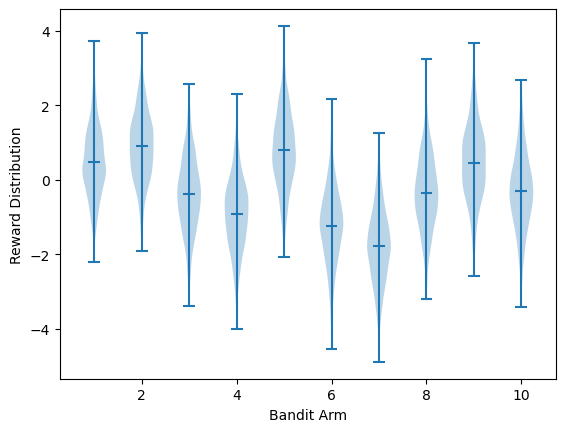

In [3]:
stationary = gym.make('ArmedBanditTestbed-v0', n=n, stationary=True)
run_episode(stationary, random_gambler)
stationary.render()

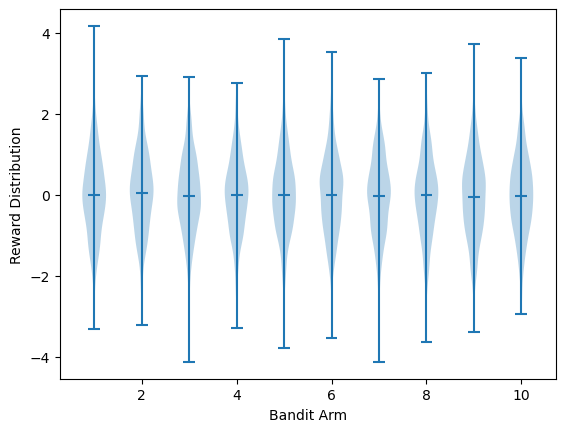

In [4]:
nonstationary = gym.make('ArmedBanditTestbed-v0', n=n, stationary=False)
nonstationary.render()

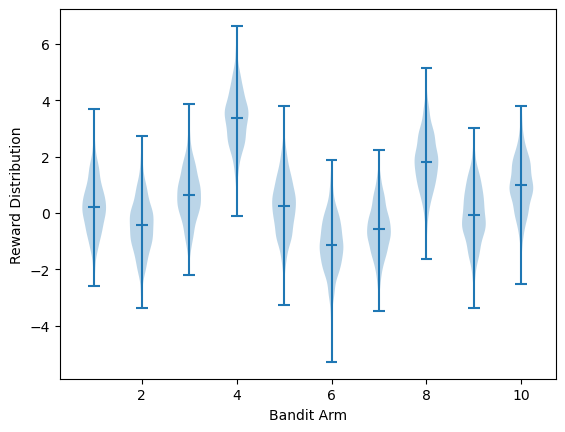

In [5]:
run_episode(nonstationary, random_gambler)
nonstationary.render()

## Exercise 2.5 - Non-Stationary Problem

Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for non-stationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean zero and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha$=0.1. Use $\epsilon$=0.1 and longer runs, say of 10,000 steps.

In [6]:
matplotlib.rcParams['figure.figsize'] = [10, 5]

ray.init(object_store_memory=1_000_000_000)

2024-03-11 17:04:15,497	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.11.5
Ray version:,2.9.3


In [7]:
@ray.remote
def ray_episode(bandit, gambler, seed: int):
    rewards, corrects, steps = run_episode(bandit, gambler, seed)
    return rewards, corrects

def run_experiments(bandit, gamblers: dict, num_episodes: int) -> dict:
    bandit_id = ray.put(bandit)
    experiments = {}
    for label, gambler in gamblers.items():
        gambler_id = ray.put(gambler)
        seed = np.random.randint(2 ** 31 - 1 - num_episodes)
        episodes = [ray_episode.remote(bandit_id, gambler_id, seed + i) for i in range(num_episodes)]
        
        rewards = 0
        corrects = 0
        while episodes:
            finished, episodes = ray.wait(episodes)
            eprews, epcors = ray.get(finished[0])
            rewards += (eprews - rewards) / (num_episodes - len(episodes))
            corrects += epcors
            
        experiments[label] = (rewards, corrects / num_episodes)
    return experiments

def plot_experiments(results: dict) -> None:
    fig_rewards = plt.figure()
    fig_corrects = plt.figure()
    
    for label, (rewards, corrects) in results.items():
        fig_rewards.gca().plot(rewards, label=label)
        fig_corrects.gca().plot(corrects, label=label)
        
    fig_rewards.gca().set_ylabel("Average reward")
    fig_rewards.gca().set_xlabel("Steps")
    fig_rewards.legend()
    
    fig_corrects.gca().set_ylabel("Optimal action")
    fig_corrects.gca().set_xlabel("Steps")
    fig_corrects.legend()

### Sample-average method for stationary problem
Fig. 2.2 re-implementation

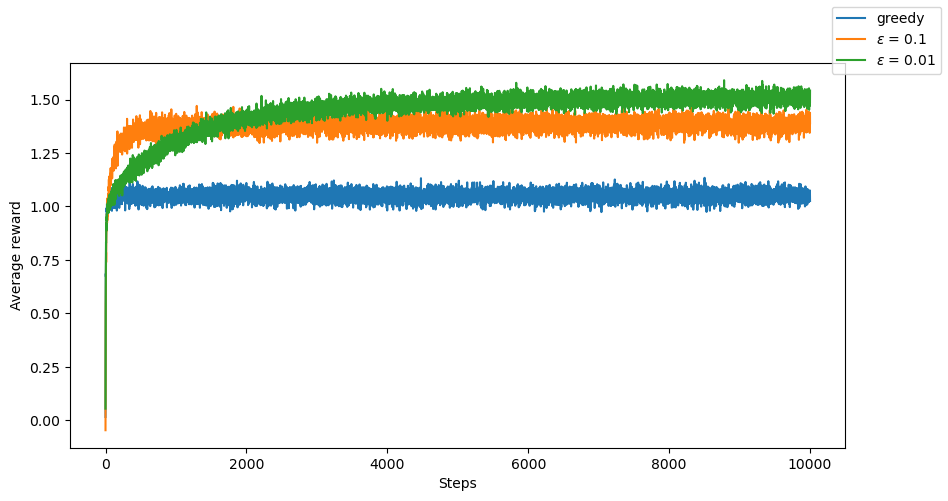

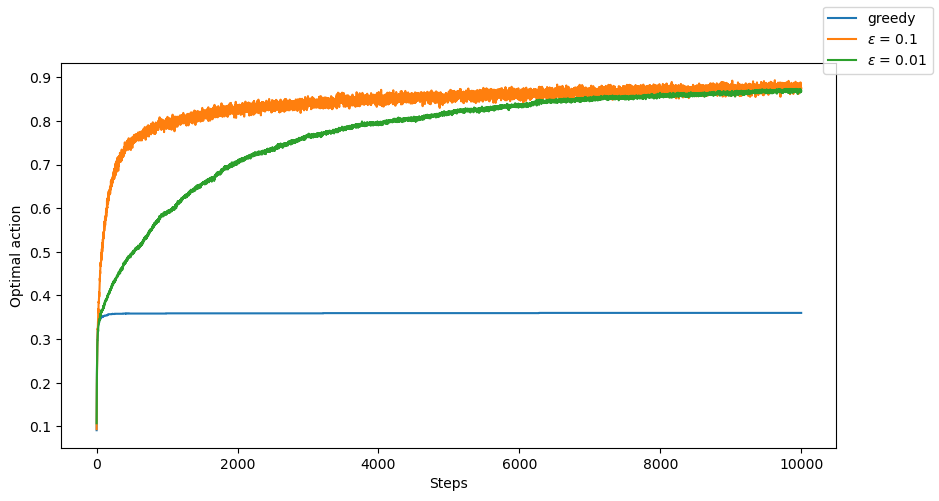

In [8]:
bandit = gym.make('ArmedBanditTestbed-v0', n=n, stationary=True) 

gamblers = {
    r"greedy": AveragingGambler(n, epsilon=0),
    r"$\epsilon$ = 0.1": AveragingGambler(n, epsilon=0.1),
    r"$\epsilon$ = 0.01": AveragingGambler(n, epsilon=0.01)
}
results = run_experiments(bandit, gamblers, num_episodes=2000)
plot_experiments(results)

### Exponential Recency Weighted method for nonstationary problem

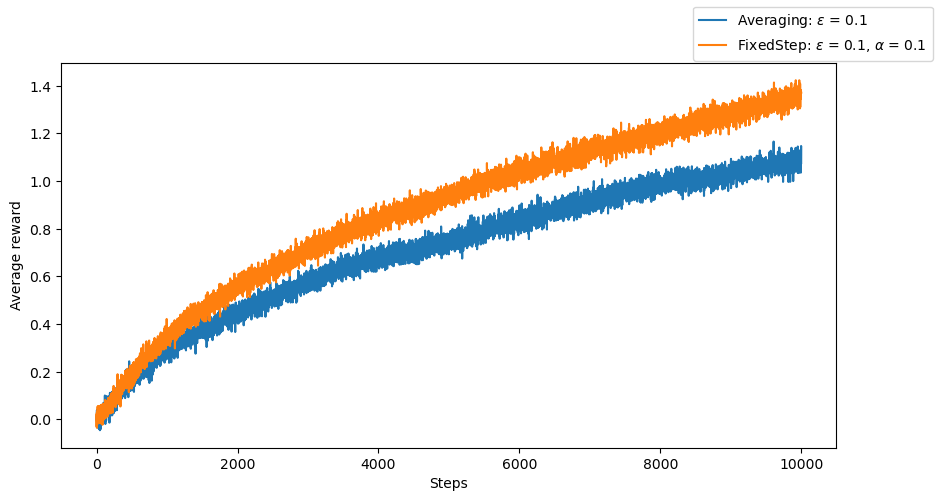

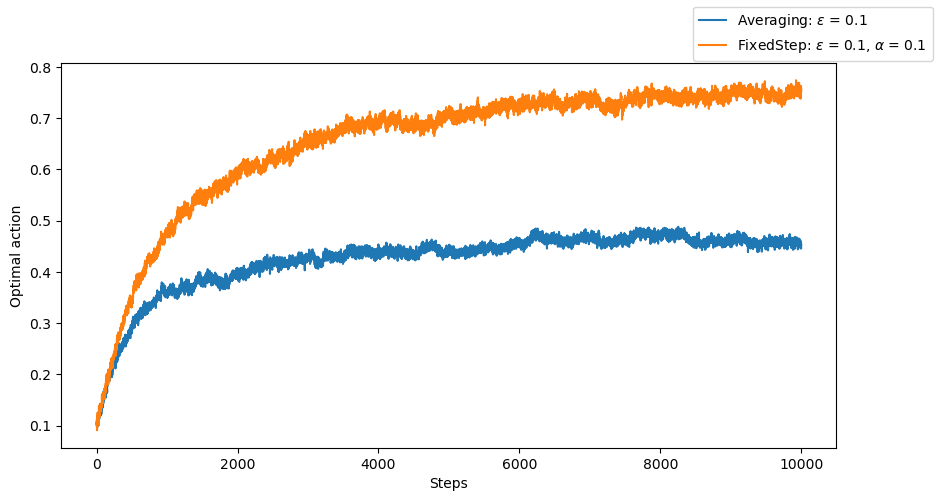

In [9]:
bandit = gym.make('ArmedBanditTestbed-v0', n=n, stationary=False) 

gamblers = {
    r"Averaging: $\epsilon$ = 0.1": AveragingGambler(n, epsilon=0.1),
    r"FixedStep: $\epsilon$ = 0.1, $\alpha$ = 0.1": EpsilonGreedyGambler(n, epsilon=0.1, alpha=0.1)
}
results = run_experiments(bandit, gamblers, num_episodes=2000)
plot_experiments(results)

### Compar'em all
#### Stationary problem

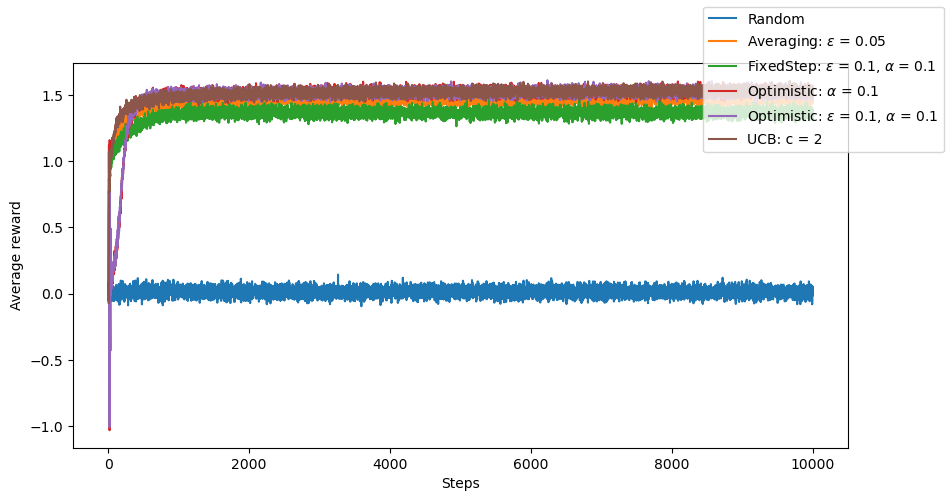

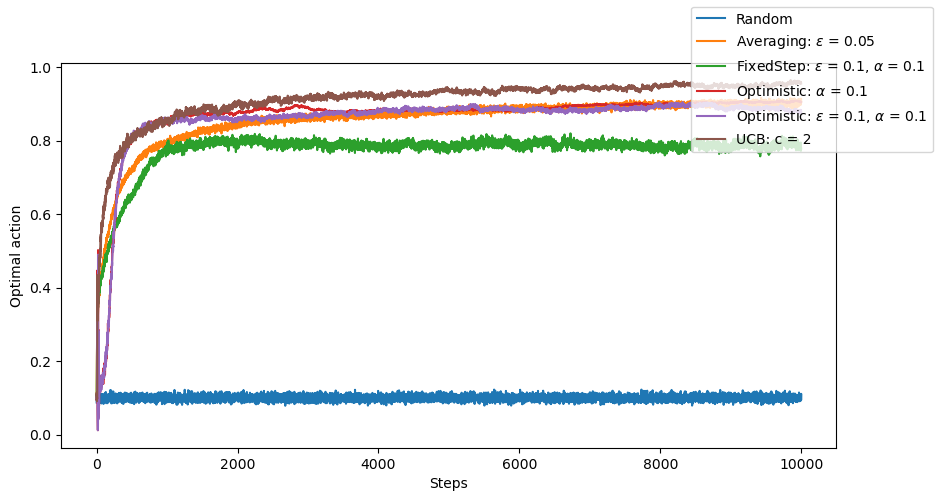

In [11]:
bandit = gym.make('ArmedBanditTestbed-v0', n=n, stationary=True) 

gamblers = {
    r"Random": RandomGambler(n),
    r"Averaging: $\epsilon$ = 0.05": AveragingGambler(n, epsilon=0.05),
    r"FixedStep: $\epsilon$ = 0.1, $\alpha$ = 0.1": EpsilonGreedyGambler(n, epsilon=0.1, alpha=0.1),
    r"Optimistic: $\alpha$ = 0.1": OptimisticGambler(n, alpha=0.1),
    r"Optimistic: $\epsilon$ = 0.1, $\alpha$ = 0.1": OptimisticGambler(n, epsilon=0.01, alpha=0.1),
    r"UCB: c = 2": UCBGambler(n, c=2)
    
}
results = run_experiments(bandit, gamblers, num_episodes=2000)
plot_experiments(results)

#### Nonstationary problem

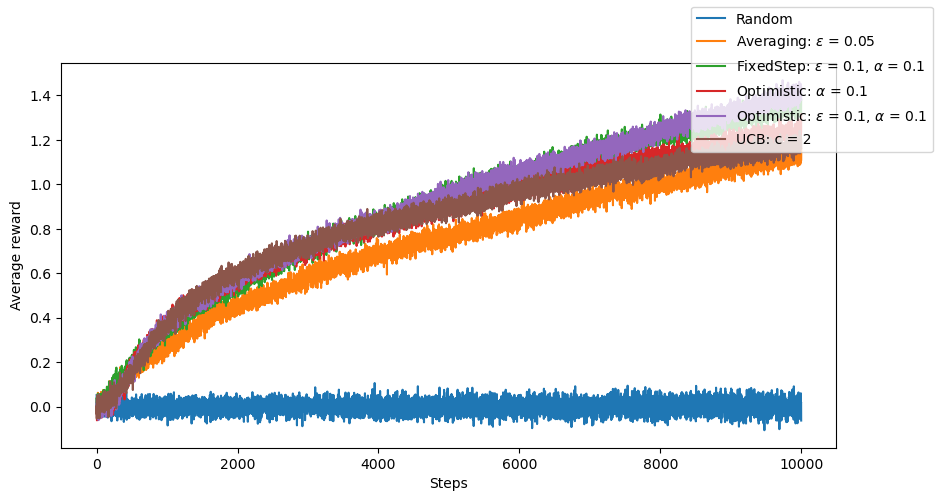

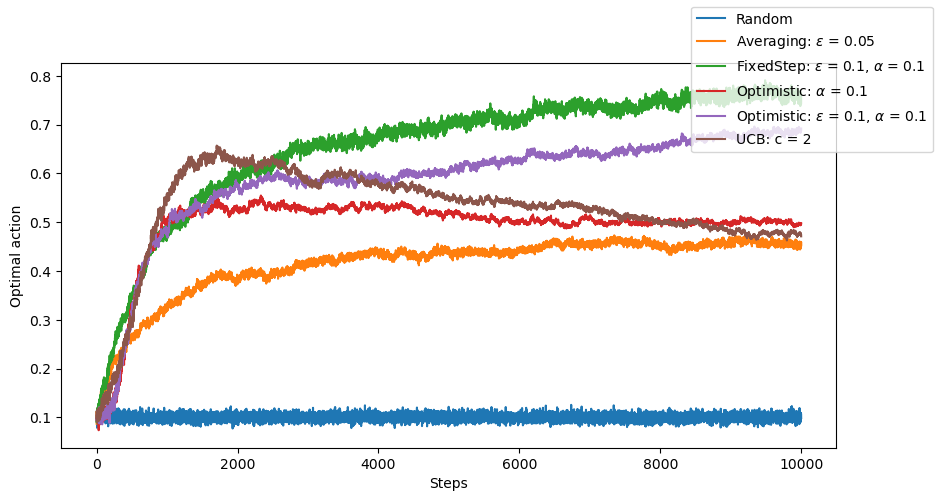

In [12]:
bandit = gym.make('ArmedBanditTestbed-v0', n=n, stationary=False) 

gamblers = {
    r"Random": RandomGambler(n),
    r"Averaging: $\epsilon$ = 0.05": AveragingGambler(n, epsilon=0.05),
    r"FixedStep: $\epsilon$ = 0.1, $\alpha$ = 0.1": EpsilonGreedyGambler(n, epsilon=0.1, alpha=0.1),
    r"Optimistic: $\alpha$ = 0.1": OptimisticGambler(n, alpha=0.1),
    r"Optimistic: $\epsilon$ = 0.1, $\alpha$ = 0.1": OptimisticGambler(n, epsilon=0.01, alpha=0.1),
    r"UCB: c = 2": UCBGambler(n, c=2)
    
}
results = run_experiments(bandit, gamblers, num_episodes=2000)
plot_experiments(results)

## Excercise 2.11 
Make a figure analogous to Figure 2.6 for the non-stationary case outlined in Exercise 2.5. Include the constant-step-size $\epsilon$-greedy algorithm with $\alpha$=0.1. Use runs of 200,000 steps and, as a performance measure for each algorithm and parameter setting, use the average reward over the last 100,000 steps.

In [13]:
stationary._max_episode_steps = 1000
nonstationary._max_episode_steps = 200000
late_reward_window = 100000
seed = np.random.randint(2 ** 31 - 1)

In [14]:
def run_experiments(bandit, gamblers: dict, num_episodes: int) -> dict:
    bandit_id = ray.put(bandit)
    experiments = {}
    for label, gambler in gamblers.items():
        gambler_id = ray.put(gambler)
        seed = np.random.randint(2 ** 31 - 1 - num_episodes)
        episodes = [ray_episode.remote(bandit_id, gambler_id, seed + i) for i in range(num_episodes)]
        
        rewards = 0
        corrects = 0
        while episodes:
            finished, episodes = ray.wait(episodes)
            eprews, epcors = ray.get(finished[0])
            rewards += (eprews - rewards) / (num_episodes - len(episodes))
            corrects += epcors
            
        experiments[label] = (rewards, corrects / num_episodes)
    return experiments

In [15]:
def run_experiment(bandit, gambler, num_episodes):
    bandit_id = ray.put(bandit)
    gambler_id = ray.put(gambler)
    seed = np.random.randint(2 ** 31 - 1 - num_episodes)
    episodes = [ray_episode.remote(bandit_id, gambler_id, seed + i) for i in range(num_episodes)]
    
    rewards = []
    late_rewards = []
    corrects = []
    while episodes:
        finished, episodes = ray.wait(episodes)
        eprews, epcors = ray.get(finished[0])
        rewards += [np.mean(eprews)]
        late_rewards += [np.mean(eprews[-late_reward_window:])]
        corrects += [np.mean(epcors)]
    return np.mean(rewards), np.mean(late_rewards), np.mean(corrects)

### Stationary problem (based on Figure 2.6)

In [25]:
results = []

#### $\epsilon$-greedy

In [84]:
def eps_greedy_experiment(bandit, grid=range(-7, -1)):
    results = []
    epsilons = [2 ** n for n in grid]
    for eps in epsilons:
        gambler = EpsilonGreedyGambler(n, alpha=0.1, epsilon=eps)
        mean_reward, mean_late_reward, mean_correct = run_experiment(bandit, gambler, num_episodes=2000)
        results.append({
            'gambler': 'EpsilonGreedy',
            'epsilon': eps, 
            'mean_reward': mean_reward, 
            'mean_late_reward': mean_late_reward, 
            'mean_correct': mean_correct,
        })
    return results

results += eps_greedy_experiment(stationary)

<Axes: xlabel='epsilon'>

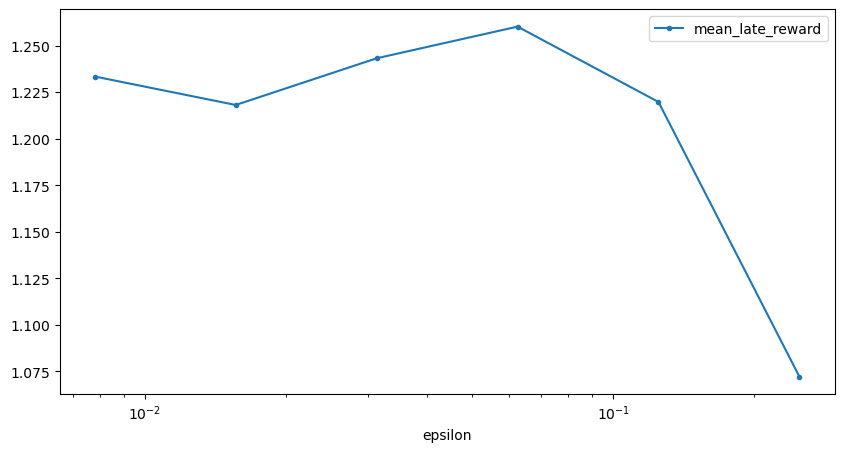

In [27]:
df = pd.DataFrame(results)
df[df.gambler == 'EpsilonGreedy'].plot(x='epsilon', y='mean_late_reward', logx=True, marker='.')

#### Optimistic

In [93]:
def optimistic_experiment(bandit, grid=range(-2, 3)):
    results = []
    inits = [2 ** n for n in grid]
    for init in inits:
        gambler = OptimisticGambler(n, epsilon=0, alpha=0.1, init=init)
        mean_reward, mean_late_reward, mean_correct = run_experiment(bandit, gambler, num_episodes=2000)
        results.append({
            'gambler': 'Optimistic',
            'init': init, 
            'mean_reward': mean_reward, 
            'mean_late_reward': mean_late_reward, 
            'mean_correct': mean_correct,
        })
    return results

results += optimistic_experiment(stationary)

<Axes: xlabel='init'>

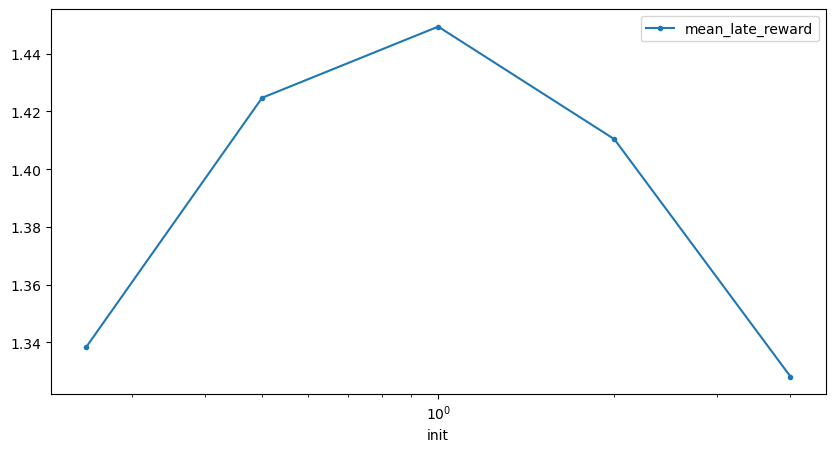

In [29]:
df = pd.DataFrame(results)
df[df.gambler == 'Optimistic'].plot(x='init', y='mean_late_reward', logx=True, marker='.')

#### UCB

In [86]:
def ucb_experiment(bandit, grid=range(-4, 3)):
    results = []
    cs = [2 ** n for n in grid]
    for c in cs:
        gambler = UCBGambler(n, c=c)
        mean_reward, mean_late_reward, mean_correct = run_experiment(bandit, gambler, num_episodes=2000)
        results.append({
            'gambler': 'UCB',
            'c': c, 
            'mean_reward': mean_reward, 
            'mean_late_reward': mean_late_reward, 
            'mean_correct': mean_correct,
        })
    return results

results += ucb_experiment(stationary)

<Axes: xlabel='c'>

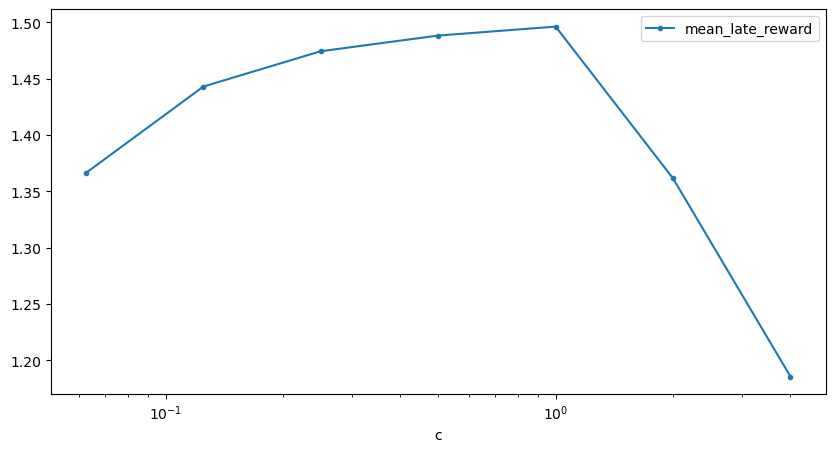

In [31]:
df = pd.DataFrame(results)
df[df.gambler == 'UCB'].plot(x='c', y='mean_late_reward', logx=True, marker='.')

#### Gradient

In [87]:
def gradient_experiment(bandit, grid=range(-5, 1)):
    results = []
    alphas = [2 ** n for n in grid]
    for alpha in alphas:
        gambler = GradientGambler(n, alpha=alpha)
        mean_reward, mean_late_reward, mean_correct = run_experiment(bandit, gambler, num_episodes=2000)
        results.append({
            'gambler': 'Gradient',
            'alpha': alpha, 
            'mean_reward': mean_reward, 
            'mean_late_reward': mean_late_reward, 
            'mean_correct': mean_correct,
        })
    return results

results += gradient_experiment(stationary)

<Axes: xlabel='alpha'>

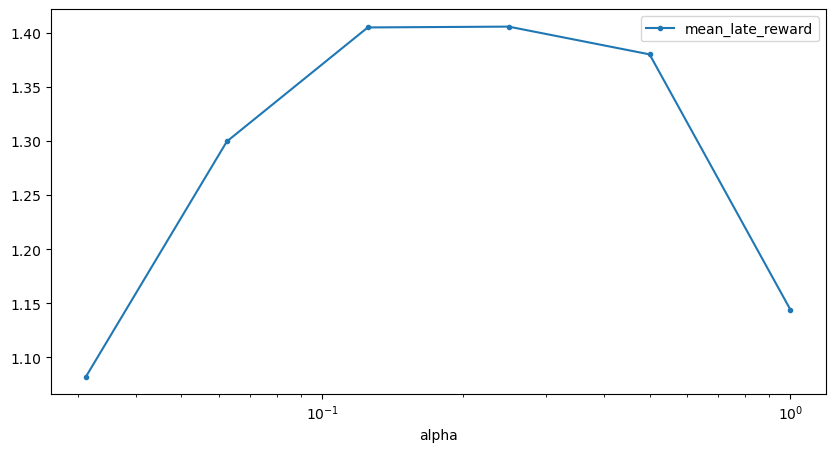

In [33]:
df = pd.DataFrame(results)
df[df.gambler == 'Gradient'].plot(x='alpha', y='mean_late_reward', logx=True, marker='.')

#### Comparison

In [53]:
def comparison_plot(df, mean='mean_late_reward'):
    fig = plt.figure()
    gca = fig.gca()
    
    dfg = df[df.gambler == 'EpsilonGreedy']
    gca.plot(dfg.epsilon, dfg[mean], marker='.', label=r'Greedy - $\epsilon$')
    
    dfg = df[df.gambler == 'Optimistic']
    gca.plot(dfg.init, dfg[mean], marker='.', label=r'Optimistic - $Q_1$')
    
    dfg = df[df.gambler == 'UCB']
    gca.plot(dfg.c, dfg[mean], marker='.', label=r'UCB - $c$')
    
    dfg = df[df.gambler == 'Gradient']
    gca.plot(dfg.alpha, dfg[mean], marker='.', label=r'Gradient - $\alpha$')
    
    gca.semilogx()
    gca.set_xlabel('Hyperparameter')
    gca.set_ylabel('Mean Reward')
    
    fig.set_size_inches(10, 5)
    fig.legend()

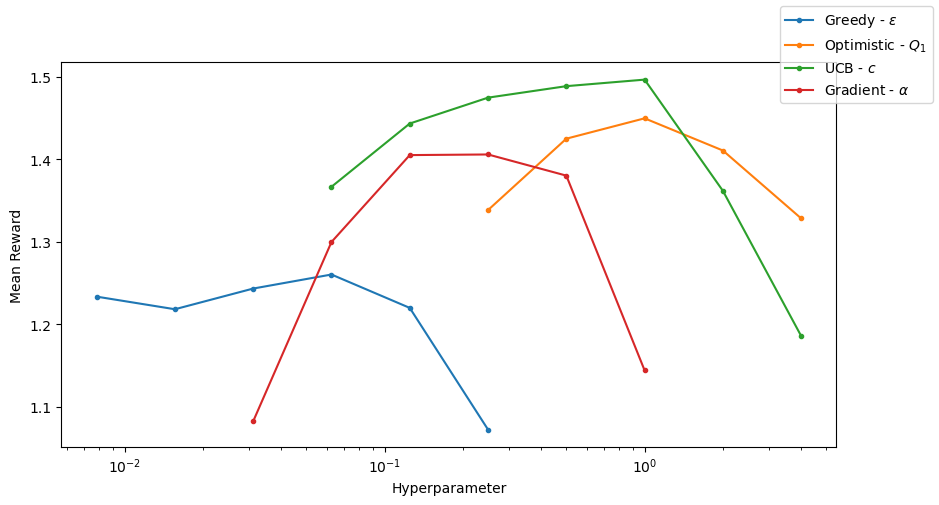

In [54]:
comparison_plot(df)

### Non-Stationary problem

In [89]:
results = []

#### $\epsilon$-greedy

In [90]:
results += eps_greedy_experiment(nonstationary, grid=range(-10, -1))

<Axes: xlabel='epsilon'>

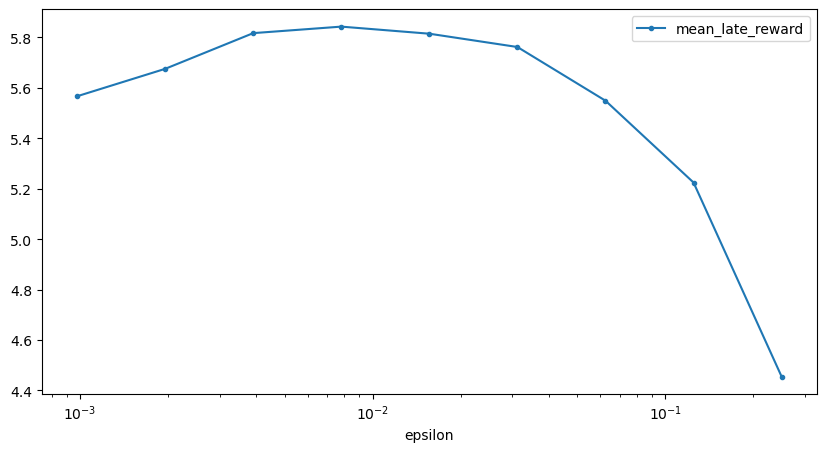

In [91]:
df = pd.DataFrame(results)
df[df.gambler == 'EpsilonGreedy'].plot(x='epsilon', y='mean_late_reward', logx=True, marker='.')

#### Optimistic

In [95]:
results += optimistic_experiment(nonstationary, grid=range(-5, 5))

<Axes: xlabel='init'>

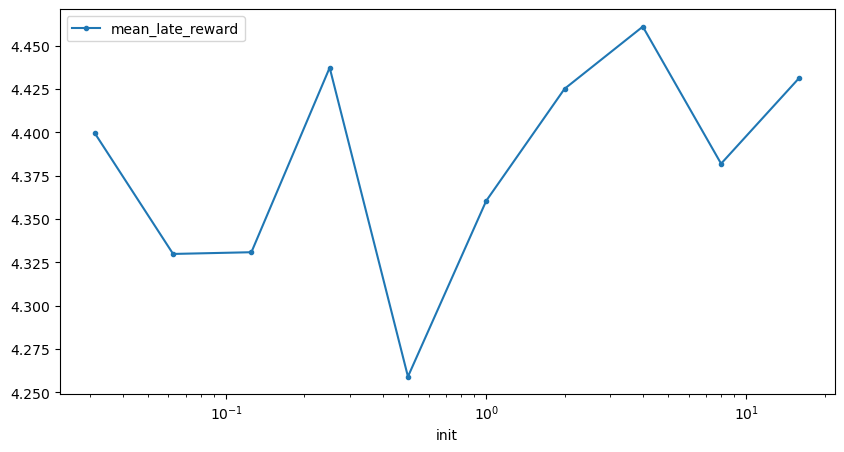

In [96]:
df = pd.DataFrame(results)
df[df.gambler == 'Optimistic'].plot(x='init', y='mean_late_reward', logx=True, marker='.')

#### UCB

In [97]:
results += ucb_experiment(nonstationary, grid=range(-1, 10))

<Axes: xlabel='c'>

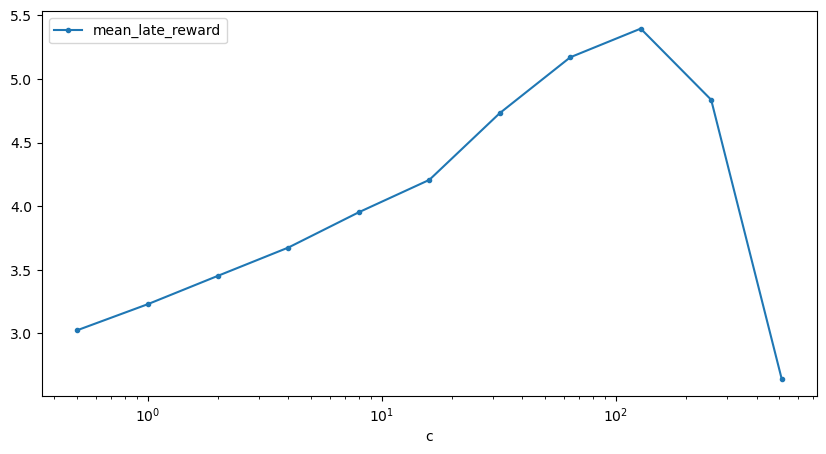

In [98]:
df = pd.DataFrame(results)
df[df.gambler == 'UCB'].plot(x='c', y='mean_late_reward', logx=True, marker='.')

#### Gradient

In [ ]:
results += gradient_experiment(nonstationary, grid=range(-10, 1))

<Axes: xlabel='alpha'>

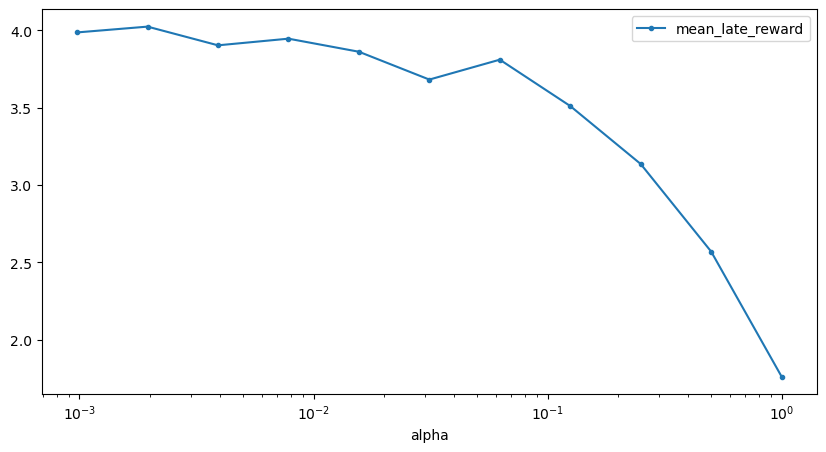

In [101]:
df = pd.DataFrame(results)
df[df.gambler == 'Gradient'].plot(x='alpha', y='mean_late_reward', logx=True, marker='.')

#### Comparison

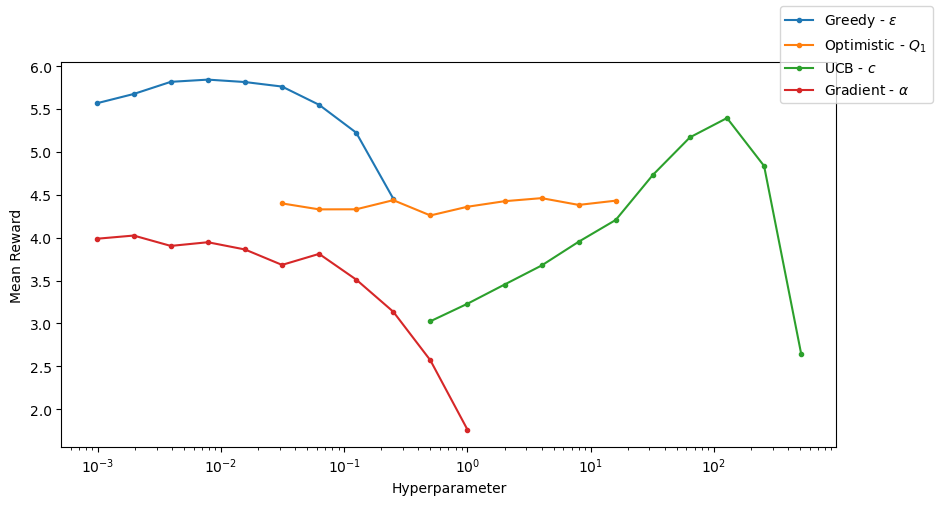

In [102]:
comparison_plot(df)